# Assignment

Karin Thommen, 16-580-011 

---
Code is based on Assignment-Template and Lab 1-3 from the Introduction to Reinforcement Learning course. 
# How to run the code 
1. Import the .py files given in the assignment 
2. Import all libraries   
3. Initialize the environment 
4. Do Initialization-Part 
5. Run Sarsa-Part for Sarsa **OR** Run Q-Learning Part 

**Remark**: If you want to ran Q-Learning after running Sarsa, the initialization has to be done again in order to reset everything

In [ ]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
from numpy import matlib
import pandas as pd

size_board = 4

## The Environment (explaination) 

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






# Initialize the Environment 

In [ ]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

## Given Examples of Random Agent

In [ ]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[0 0 0 0]
 [0 0 2 0]
 [3 0 0 0]
 [0 0 1 0]]
check?  0
dofk2  0

[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [3 0 1 0]]
0  0
check?  0
dofk2  0

[[0 0 0 0]
 [0 0 0 0]
 [0 2 0 0]
 [3 0 1 0]]
1  1
check?  1
dofk2  0


In [ ]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.212 Number of steps:  7.162


# Initialization

In [ ]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 

S,X,allowed_a=env.Initialise_game()
N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

N_in=np.shape(X)[0]    ## INPUT SIZE
N_h=200                ## NUMBER OF HIDDEN NODES

N_o = N_a 

## INITALISE YOUR NEURAL NETWORK...
# based on Lab Code 

W1 = np.random.uniform(0,1,(N_h, N_in)) # ADDED 
W2 = np.random.uniform(0,1,(N_o, N_h)) # ADDED 
# normalise the random weights so that the sum of each row =1
W1 = np.divide(W1,np.matlib.repmat(np.sum(W1,1)[:,None],1,N_in)) # ADDED 
W2 = np.divide(W2,np.matlib.repmat(np.sum(W2,1)[:,None],1,N_h)) # ADDED 
# Add bias 
bias_W1 = np.zeros((N_h,)) # ADDED 
bias_W2 = np.zeros((N_o,)) # ADDED 


# ADDED: EPSILON GREEDY (based on Lab code)

def EpsilonGreedy_Policy(Qvalues, allowed, epsilon): 
    N_a=np.shape(Qvalues)[0]
    rand_value=np.random.uniform(0,1)
    rand_a=rand_value<epsilon

    if rand_a==True:
        a=np.random.randint(0,N_a)

        while not a in allowed: 
          # if a is not an allowed action, do as much as random choices 
          # until an allowed action is choosen 
          a=np.random.randint(0,N_a)

    else:
        a=np.argmax(Qvalues)
        while not a in allowed: 
          # if the max Q value is not an allowed action, set value temporary 
          # to a very low value and choose the next max q value instead.
          #  repeat until the highest q value of an allowed action is found 
          Qvalues[a] = -10000 
          a = np.argmax(Qvalues) 
            
    return a
    
# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)
epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY (given value 0.2)
beta = 0.00005    # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW) (given 0.00005)
gamma = 0.85     # THE DISCOUNT FACTOR (given 0.85)
eta = 0.0035        # THE LEARNING RATE (given 0.0035)

N_episodes = 100000 # THE NUMBER OF GAMES TO BE PLAYED (given 100000)

#N_s = np.shape(S)[0]
Qtable=np.random.randn(3500, N_a)/1000 # ADDED 
#greedy = np.argmax(Qtable,1) 
#actions = EpsilonGreedy_Policy(Qtable, epsilon_0) 
Q_lookup = {} # look up table where the different possible states are saved. 
known = 0 # variable that is used for the indexing 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])

C_save = np.zeros([N_episodes, 1]) # Added to count checks, not needed, shows same as rewards 

# SARSA

In [ ]:
# SARSA 
checks = 0 

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    #print(n)                                 ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING

    while Done==0:                           ## START THE EPISODE
        
        # GET STATE NUMBER 
        k = list(Q_lookup.keys()) # look up the keys (index of specific state) 
        v = list(Q_lookup.values()) # look up the values (states) 
        S_lookup = S.tolist() # convert the state to a list for comparison 

        if S_lookup in v:  # check if the given state of the game is already saved
          position = v.index(S.tolist()) # get position of the state in the list 
          state = k[position] # access state number via position in list 

        else:  # state is not in list 
          Q_lookup[known] = S_lookup # save the state to the list  
          state = known # set current index as state number 
          known += 1 
          

        a,_=np.where(allowed_a==1) # find allowed actions 
        
        Qvalues = Qtable[state] # get values at specific state, not needed, just for debugging   

        a_agent = EpsilonGreedy_Policy(Qvalues, a, epsilon_f) # choose current action with epsilon greedy 
         
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent) # do step, find next state and allowed actions  
 
        
        # GET STATE NUMBER in a similar way as above 
        k_next = list(Q_lookup.keys())
        v_next = list(Q_lookup.values()) 

        if not isinstance(S_next, list): # some error occurred. needed in case that S_next is already a list 
          X_lookup_next = S_next.tolist()
        else: 
          X_lookup_next = S_next

        if X_lookup_next in v_next:  
          position_next = v_next.index(X_lookup_next)
          state_next = k_next[position_next] 

        else: 
          Q_lookup[known] = X_lookup_next
          state_next = known 
          known += 1 


        if Done != 1:     # in the case that we are not in the last part of an episode and the game continues     
          a_agent_next ,_= np.where(allowed_a_next==1) # find next allowed actoins 
          
          Qvalues_next = Qtable[state_next]  # for debugging 

          a_next = EpsilonGreedy_Policy(Qvalues_next, a_agent_next, epsilon_f)  # do epsilon greedy on next allowed actions to get next action 

          next_value = Qtable[state_next, a_next] # for debugging 

          # update the Q table according to given states and actions (current and next) 
          Qtable[state, a_agent] = Qtable[state, a_agent] + eta * (R + gamma * Qtable[state_next, a_next] - Qtable[state, a_agent])


        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1: 
            R_save[n]=np.copy(R)
            N_moves_save[n]=np.copy(i) 
            C_save[n] = env.check 

            if env.check == 1: # count checks 
              checks += 1        
            break
      
        # IF THE EPISODE IS NOT OVER...
        else:
            ## ONLY TO PUT SUMETHING
            PIPPO=1


        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

print('Sarsa_Agent, Average reward:',np.mean(R_save),'Number of steps: ',np.mean(N_moves_save), 'Number of checks:', checks, 'from ', N_episodes)


Sarsa_Agent, Average reward: 0.24504 Number of steps:  4.92239 Number of checks: 24504 from  100000


In [ ]:
'''
# PLOTS (REWARDS AND STEPS)
plt.figure(figsize = (10,3))
R_save_data = pd.Series(R_save.flatten())
mov_rev = R_save_data.rolling(window=20000).mean() #Moving Average
plt.plot(mov_rev)
plt.xlabel("Number of episodes")
plt.ylabel('Reward per episode (moving average 20000)')
plt.title("SARSA: Training results on rewards per game")
plt.show()

plt.figure(figsize = (10,3))
N_moves_save_data = pd.Series(N_moves_save.flatten())
mov_moves = N_moves_save_data.rolling(window=20000).mean() #Moving Average
plt.plot(mov_moves)
plt.xlabel("Number of episodes")
plt.ylabel('Number of moves (moving average 20000)')
plt.title("SARSA: Training results on number of moves per game")
plt.show()
'''

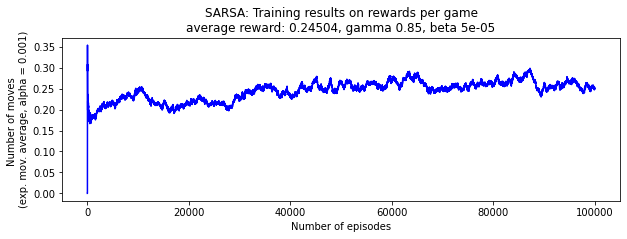

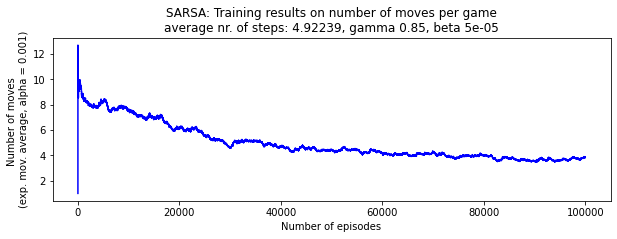

In [ ]:
# PLOTS (REWARDS AND STEPS)
plt.figure(figsize = (10,3))
R_data_s = pd.DataFrame({'moves' : R_save.flatten()})
exp_R_s = R_data_s.ewm(alpha=0.001).mean()
plt.plot(exp_R_s, 'blue')
plt.xlabel("Number of episodes")
plt.ylabel('Number of moves \n(exp. mov. average, alpha = 0.001)')
plt.title("SARSA: Training results on rewards per game\naverage reward: {}, gamma {}, beta {}".format(np.mean(R_save), gamma, beta))
plt.show()

plt.figure(figsize = (10,3))
N_moves_save_data_s = pd.DataFrame({'moves' : N_moves_save.flatten()})
exp_moves_s = N_moves_save_data_s.ewm(alpha=0.001).mean()
plt.plot(exp_moves_s, 'blue')
plt.xlabel("Number of episodes")
plt.ylabel('Number of moves \n(exp. mov. average, alpha = 0.001)')
plt.title("SARSA: Training results on number of moves per game\naverage nr. of steps: {}, gamma {}, beta {}".format(np.mean(N_moves_save), gamma, beta))
plt.show()

## Experimenting with gaming without updating Q values 

In [ ]:
'''
Q_saved = np.copy(Qtable)
Q_lookup_save = Q_lookup.copy()
'''

In [ ]:
''' 
# PLAYING THE GAME 

N_episodes=5000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_sarsa = np.zeros([N_episodes, 1])
N_moves_sarsa = np.zeros([N_episodes, 1])
C_save_sarsa = np.zeros([N_episodes, 1])

key = list(Q_lookup_save.keys())
val = list(Q_lookup_save.values())

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    print(n)

    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
                
        a,_=np.where(allowed_a==1) # get allowed actions 

        # SEARCH STATE IN Q TABLE        
        if np.sum(S) == 6: 
          position = val.index(S.tolist())
          current_state = key[position] 
                    
          Qvalues = Q_saved[current_state] # get values at specific state 

          # PERFORM ACTION BUT DO NOT UPDATE THE Q TABLE 
          a_agent = EpsilonGreedy_Policy(Qvalues, a, epsilon_f) # do greedy search at given q values in q table 
          
          S,X,allowed_a,R,Done=env.OneStep(a_agent)

        elif np.sum(S) != 6: 
          print(S)
          break 

        if Done:
            R_save_sarsa[n]=np.copy(R) 
            N_moves_sarsa[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER


print('Sarsa Testing, Average reward:',np.mean(R_save_sarsa),'Number of steps: ',np.mean(N_moves_sarsa))


'''

# Q-LEARNING

In [21]:
# Q-LEARNING 

checks = 0 

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    #print(n)                                 ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING

    while Done==0:                           ## START THE EPISODE
        # GET STATE NUMBER 
        k = list(Q_lookup.keys()) # look up the keys (index of specific state) 
        v = list(Q_lookup.values()) # look up the values (states) 
        S_lookup = S.tolist() # convert the state to a list for comparison 

        if S_lookup in v:  # check if the given state of the game is already saved
          position = v.index(S.tolist()) # get position of the state in the list 
          state = k[position] # access state number via position in list 

        else:  # state is not in list 
          Q_lookup[known] = S_lookup # save the state to the list  
          state = known # set current index as state number 
          known += 1 
          

        a,_=np.where(allowed_a==1) # find allowed actions 
        
        Qvalues = Qtable[state] # get values at specific state, not needed, just for debugging   

        a_agent = EpsilonGreedy_Policy(Qvalues, a, epsilon_f) # choose current action with epsilon greedy 
         
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent) # do step, find next state and allowed actions  
 
        
        # GET STATE NUMBER in a similar way as above 
        k_next = list(Q_lookup.keys())
        v_next = list(Q_lookup.values()) 

        if not isinstance(S_next, list): # some error occurred. needed in case that S_next is already a list 
          X_lookup_next = S_next.tolist()
        else: 
          X_lookup_next = S_next

        if X_lookup_next in v_next:  
          position_next = v_next.index(X_lookup_next)
          state_next = k_next[position_next] 

        else: 
          Q_lookup[known] = X_lookup_next
          state_next = known 
          known += 1 


        if Done != 1:     # in the case that we are not in the last part of an episode and the game continues     
          a_agent_next ,_= np.where(allowed_a_next==1) # find next allowed actoins 
          
          Qvalues_next = Qtable[state_next]  # for debugging 

          next_value = np.max(Qtable[state_next]) # for debugging 

          # update Q table according to actions
          Qtable[state, a_agent] = Qtable[state, a_agent] + eta * (R - Qtable[state, a_agent] + gamma * np.max(Qtable[state_next]))
           
          a_next = EpsilonGreedy_Policy(Qvalues_next, a_agent_next, epsilon_f)  # do epsilon greedy 


        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1: 
            R_save[n]=np.copy(R)
            N_moves_save[n]=np.copy(i) 
            C_save[n] = env.check 

            if env.check == 1: 
              checks += 1        
            break
      
        # IF THE EPISODE IS NOT OVER...
        else:
            ## ONLY TO PUT SUMETHING
            PIPPO=1


        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

print('QL_Agent, Average reward:',np.mean(R_save),'Number of steps: ',np.mean(N_moves_save), 'Number of checks:', checks, 'from ', N_episodes)







QL_Agent, Average reward: 0.19199 Number of steps:  5.21547 Number of checks: 19199 from  100000


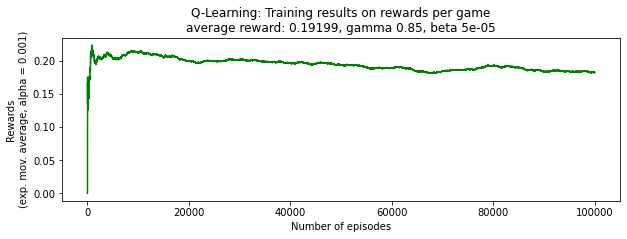

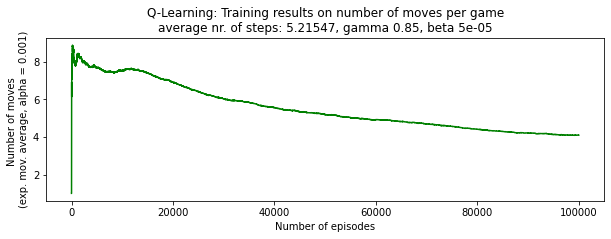

In [22]:
# PLOTS (REWARDS AND STEPS)
plt.figure(figsize = (10,3))
R_data_q = pd.DataFrame({'moves' : R_save.flatten()})
exp_R_q = R_data_q.ewm(span=20000).mean()
plt.plot(exp_R_q, 'g')

plt.xlabel("Number of episodes")
plt.ylabel('Rewards \n(exp. mov. average, alpha = 0.001)')
plt.title("Q-Learning: Training results on rewards per game\naverage reward: {}, gamma {}, beta {}".format(np.mean(R_save), gamma, beta))
plt.show()

plt.figure(figsize = (10,3))
N_moves_save_data_q = pd.DataFrame({'moves' : N_moves_save.flatten()})
exp_moves_q = N_moves_save_data_q.ewm(alpha=0.0001).mean()
plt.plot(exp_moves_q, 'g')
plt.xlabel("Number of episodes")
plt.ylabel('Number of moves \n(exp. mov. average, alpha = 0.001)')
plt.title("Q-Learning: Training results on number of moves per game\naverage nr. of steps: {}, gamma {}, beta {}".format(np.mean(N_moves_save), gamma, beta))
plt.show()

# Given Training Loop (Random Agent) 

In [ ]:
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...

for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    print(n)                                 ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING
    
    while Done==0:                           ## START THE EPISODE
        
        
        ## THIS IS A RANDOM AGENT, CHANGE IT...
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]                
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)
        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            
            
            break
        
               
        # IF THE EPISODE IS NOT OVER...
        else:
            
            ## ONLY TO PUT SUMETHING
            PIPPO=1
            
           
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
        S=np.copy(S_next)
        X=np.copy(X_next)
        allowed_a=np.copy(allowed_a_next)
        
        i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

        
        
    
    